# VAE

In [73]:
import sys
import os
import seaborn as sns
sys.path.append( '..' )

from VAE.smac_runhistories import *
from VAE.vae import *

## Parameter definition

In [74]:
data_dir  = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/runs/FIA/Com8_grown_together/oms"))
run_dir = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/runs/VAE/hyperparameter_optimization"))
results_dir = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/runs/VAE/results"))
verbosity = 1
backend_name = "tensorflow"
computation = "gpu"
outdir = Path(os.path.normpath(os.path.join(run_dir, f"smac_vae_{backend_name}_{computation}")))

time_step(message="Setup loaded", verbosity=verbosity)

X = read_data(data_dir, verbosity=verbosity)

Setup loaded (1500.8259372711182s)
Data loaded (3.5962893962860107s)


## Training

In [75]:
# On cluster


In [76]:
backend_name = "tensorflow"
computation = "gpu"
name = "tied_mae_cos_fin"
project = f"vae_{backend_name}_{computation}_{name}"
outdir = Path(os.path.normpath( os.path.join("/mnt/d/runs/VAE/training", project)))

In [77]:
model = keras.saving.load_model(os.path.join(outdir, f"{project}_best.keras"), custom_objects=None, compile=True, safe_mode=True)

In [78]:
model.summary()

Model: "fia_vae_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_3                │ ?                      │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_intermediate            │ ?                      │   148,523,710 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_mu (Dense)               │ ?                      │        17,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_sigma (Dense)            │ ?                      │        17,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_reparametrization        │ ?                      │             0 │
│ (Sampling)                      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Sequential)            │ ?                      │   149,348,890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 448,148,853 (1.67 GB)

 Trainable params: 149,382,950 (569.85 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 298,765,903 (1.11 GB)

## Reconstruction

In [79]:
reconstructed_data = pd.DataFrame( model(X).numpy() )

### Show model

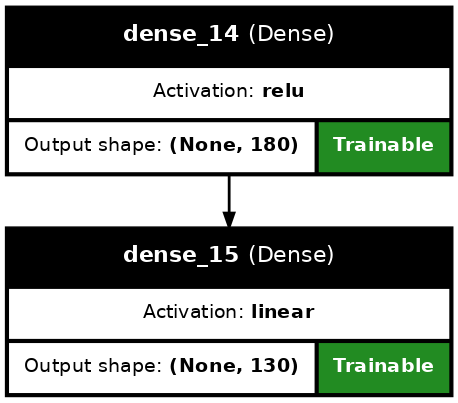

In [80]:
model_plot = keras.utils.plot_model( model.get_layer(index=2), show_shapes=True, show_dtype=False, show_layer_names=True,
                                     rankdir="TB", expand_nested=True, dpi=100, to_file="../../reports/model.png",
                                     show_layer_activations=True, show_trainable=True )
model_plot

## Plot training

In [81]:
history = pd.read_csv(os.path.join(outdir, f"{project}.history.tsv"), sep="\t", index_col="Unnamed: 0")
history

,kl_loss,loss,reconstruction_loss,val_kl_loss,val_loss,val_reconstruction_loss
0,0.003816,0.986691,0.979266,0.000459,0.979365,0.978270
1,0.000726,0.978512,0.976638,0.000059,0.976718,0.976578
2,0.000121,0.974620,0.974326,0.000030,0.973833,0.973762
3,0.000087,0.971730,0.971531,0.000033,0.971169,0.971091
4,0.000108,0.968628,0.968384,0.000025,0.966934,0.966875
...,...,...,...,...,...,...
995,0.000031,0.056935,0.056860,0.000008,0.052109,0.052089
996,0.000029,0.058391,0.058327,0.000012,0.051930,0.051901
997,0.000026,0.056775,0.056713,0.000012,0.051933,0.051904
998,0.000030,0.057774,0.057703,0.000007,0.052755,0.052738


In [82]:
training_losses = history[[col for col in history.columns if not col.startswith("val")]]
validation_losses = history[[col for col in history.columns if col.startswith("val")]]

## Plot results

In [83]:
# reconstructed_data = pd.read_csv("/mnt/d/runs/VAE/training/vae_tensorflow_cpu_hm_1/vae_tensorflow_cpu_hm_1.prediction.tsv", index_col="Unnamed: 0")#, sep="\t")

In [113]:
plot_df = pd.DataFrame(reconstructed_data.loc[2].values / 40 , index=X.columns, columns=["inty"]).reset_index()    # Adjustment by scale
plot_df_2 = pd.DataFrame(X.iloc[2].values, index=X.columns, columns=["inty"]).reset_index()

In [103]:
mae = np.mean( np.abs((plot_df_2["inty"] - plot_df["inty"])) )
ae = np.sum( np.abs((plot_df_2["inty"] - plot_df["inty"])) )

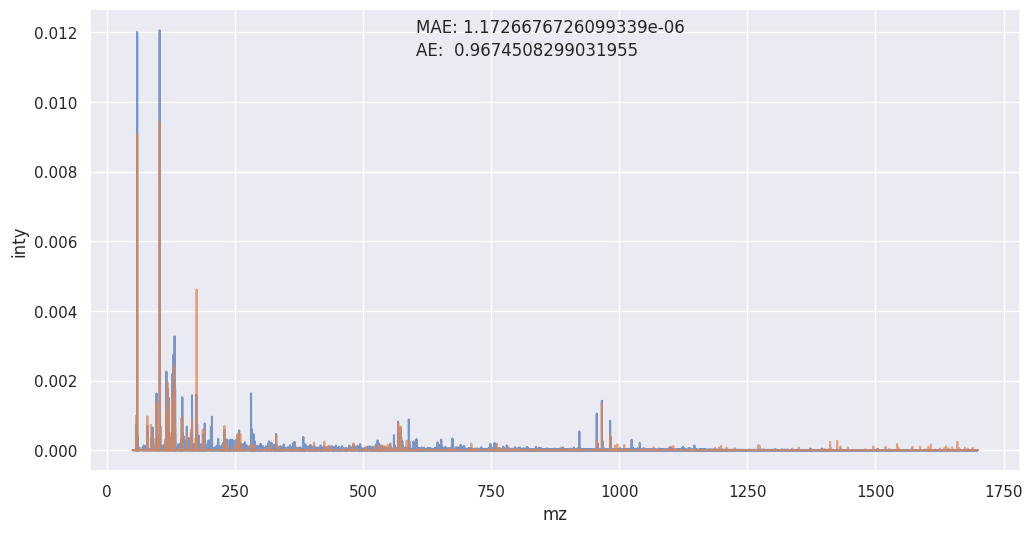

In [112]:
sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty", alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
plt.annotate(f"MAE: {mae}", xy=(0.35, 0.95), xycoords='axes fraction')
plt.annotate(f"AE:  {ae}", xy=(0.35, 0.90), xycoords='axes fraction')
plt.show()

(965.9, 966.1)

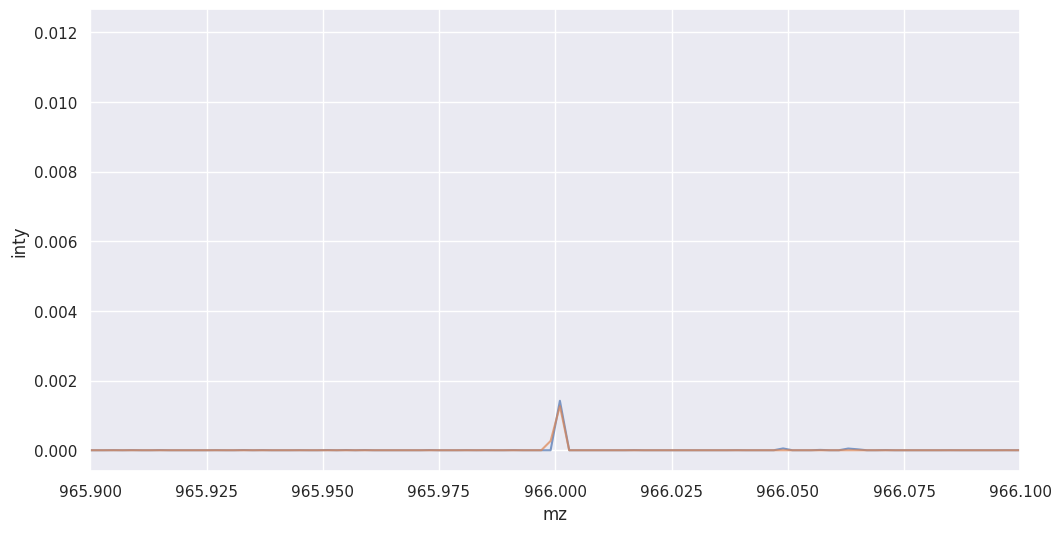

In [98]:
sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty" ,alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
ax.set_xlim(965.9, 966.1)

(-0.0001, 0.003)

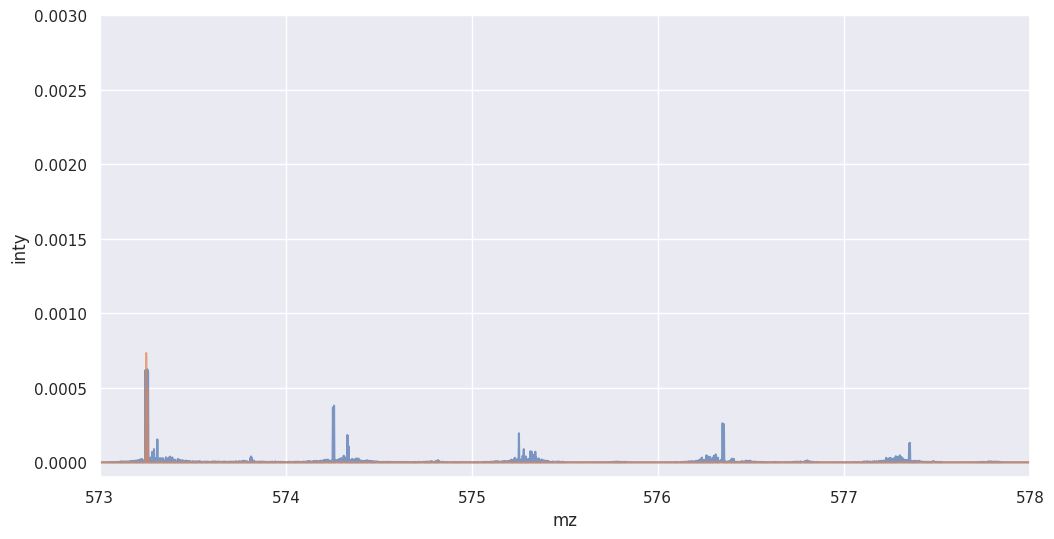

In [99]:
sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty" ,alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
ax.set_xlim(573, 578)
ax.set_ylim(-0.0001, 0.003)

(-0.0001, 0.0022)

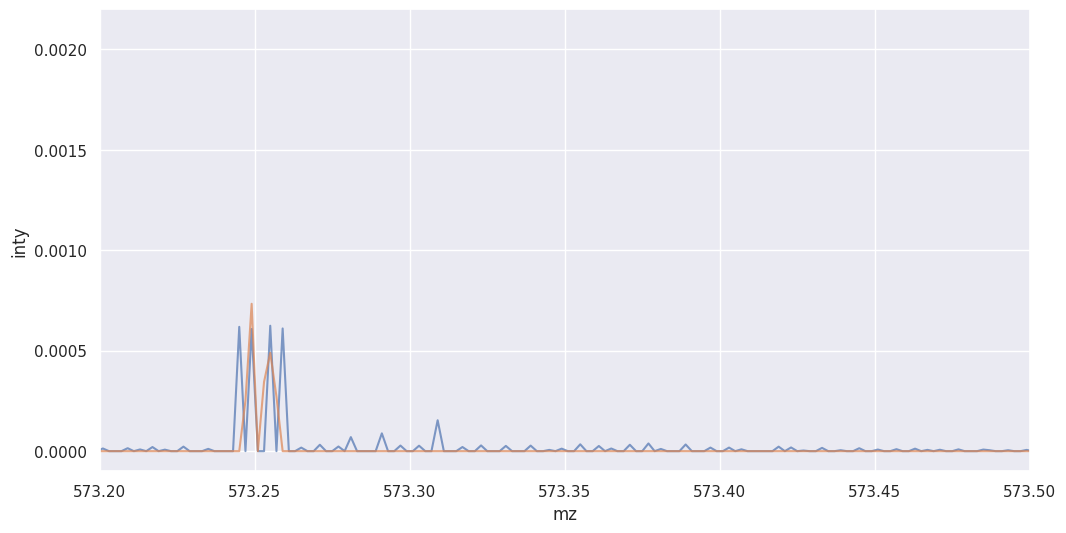

In [101]:
sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty" ,alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
ax.set_xlim(573.2, 573.5)
ax.set_ylim(-0.0001, 0.0022)

## Classification

In [90]:
vae_enc = pd.DataFrame( model.encode_mu(X) )
vae_enc

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
0,-0.000023,0.000017,-0.000026,-0.000047,-0.000037,0.000003,-0.000021,-0.000047,-0.000011,-0.00002,...,-0.00005,0.000008,0.000068,0.000001,-0.00001,0.000007,-0.000095,0.000081,-0.00006,-0.000001
1,-0.000023,0.000017,-0.000026,-0.000047,-0.000037,0.000003,-0.000021,-0.000047,-0.000011,-0.00002,...,-0.00005,0.000008,0.000068,0.000001,-0.00001,0.000007,-0.000095,0.000081,-0.00006,-0.000001
2,-0.000023,0.000017,-0.000026,-0.000047,-0.000037,0.000003,-0.000021,-0.000047,-0.000011,-0.00002,...,-0.00005,0.000008,0.000068,0.000001,-0.00001,0.000007,-0.000095,0.000081,-0.00006,-0.000001
3,-0.000023,0.000017,-0.000026,-0.000047,-0.000037,0.000003,-0.000021,-0.000047,-0.000011,-0.00002,...,-0.00005,0.000008,0.000068,0.000001,-0.00001,0.000007,-0.000095,0.000081,-0.00006,-0.000001
4,-0.000023,0.000017,-0.000026,-0.000047,-0.000037,0.000003,-0.000021,-0.000047,-0.000011,-0.00002,...,-0.00005,0.000008,0.000068,0.000001,-0.00001,0.000007,-0.000095,0.000081,-0.00006,-0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,-0.000023,0.000017,-0.000026,-0.000047,-0.000037,0.000003,-0.000021,-0.000047,-0.000011,-0.00002,...,-0.00005,0.000008,0.000068,0.000001,-0.00001,0.000007,-0.000095,0.000081,-0.00006,-0.000001
64,-0.000023,0.000017,-0.000026,-0.000047,-0.000037,0.000003,-0.000021,-0.000047,-0.000011,-0.00002,...,-0.00005,0.000008,0.000068,0.000001,-0.00001,0.000007,-0.000095,0.000081,-0.00006,-0.000001
65,-0.000023,0.000017,-0.000026,-0.000047,-0.000037,0.000003,-0.000021,-0.000047,-0.000011,-0.00002,...,-0.00005,0.000008,0.000068,0.000001,-0.00001,0.000007,-0.000095,0.000081,-0.00006,-0.000001
66,-0.000023,0.000017,-0.000026,-0.000047,-0.000037,0.000003,-0.000021,-0.000047,-0.000011,-0.00002,...,-0.00005,0.000008,0.000068,0.000001,-0.00001,0.000007,-0.000095,0.000081,-0.00006,-0.000001


In [91]:
vae_enc.to_csv( os.path.join("/mnt/d/runs/VAE/results", "encoded_mu_tied_maecos.tsv"), sep="\t" )